In [1]:
%matplotlib inline

import os
import os.path as op
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Day 4. Voxel-Based Morphometry on MRiShare dataset
============================================

This example uses Voxel-Based Morphometry (VBM) to study the relationship
between aging, sex and gray matter density.

The data come from the MRiShare database, which have been processed with 
SPM12 New Segment VBM pipeline inside ABACI to create VBM maps.


VBM analysis of aging
---------------------

We run a standard GLM analysis to study the association between age
and gray matter density from the VBM data. We use only 100 subjects
from the MRiShare dataset to limit the memory usage.

Note that more power would be obtained from using a larger sample of subjects.



In [ ]:
# Authors: Bertrand Thirion, <bertrand.thirion@inria.fr>, July 2018
#          Elvis Dhomatob, <elvis.dohmatob@inria.fr>, Apr. 2014
#          Virgile Fritsch, <virgile.fritsch@inria.fr>, Apr 2014
#          Gael Varoquaux, Apr 2014
# Modified by Ami Tsuchida <atsuch@gmail.com>, July, 2019

Examine MRiShare dataset
------------------

### 1. Independent variables used for the analyses


In [2]:
dat_dir = '../data/'
sub_info = pd.read_csv(op.join(dat_dir, 'sample_mrishare_subinfo.csv'), index_col=0)
sub_info.head()

,Sex,Handedness,Age,Score
mrishare_id,,,,
SHARE0001,M,D,24.241,93.732513
SHARE0002,F,D,22.943,125.112598
SHARE0004,M,D,23.107,91.241367
SHARE0006,M,D,22.916,121.776685
SHARE0007,M,D,20.011,103.942988


In [3]:
n_subjects = len(sub_info)
n_subjects

100

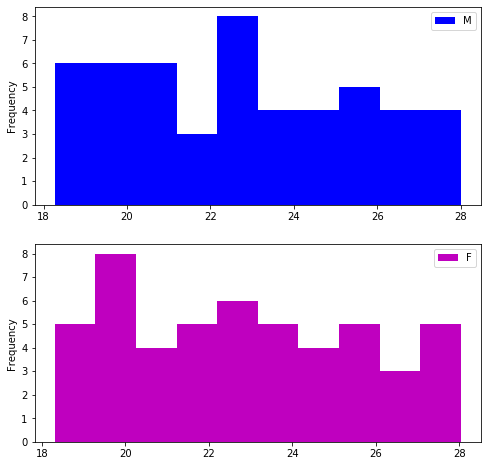

In [4]:
# Check number of subjects and age distribution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
sub_info[sub_info.Sex=='M']['Age'].plot.hist(color='b', ax=ax1)
ax1.legend('M')
sub_info[sub_info.Sex=='F']['Age'].plot.hist(color='m', ax=ax2)
ax2.legend('F')

In [5]:
grouped = sub_info.groupby('Sex')
grouped.describe()

Age                                                                 \
    count      mean       std     min     25%      50%       75%     max   
Sex                                                                        
F    50.0  22.86300  2.808525  18.308  20.262  22.9035  25.31075  28.030   
M    50.0  22.77346  2.810946  18.272  20.296  22.8570  25.08700  27.995   

    Score                                                           \
    count        mean        std        min        25%         50%   
Sex                                                                  
F    50.0   97.233923  14.671722  72.523768  87.944829   96.525077   
M    50.0  100.832464  14.128692  70.649083  92.218571  101.402686   

                             
            75%         max  
Sex                          
F    110.221035  125.112598  
M    108.402293  130.525952

### 2. GM volume image (modulated image in MNI space, 1x1x1mm)

Jacobian modulated GM image in MNI space based on two-channel (i.e. T1 and FLAIR) tissue-segmentation for the same 100 subjects are in the /data/rw_eleves/Cajal-Morphometry2019/copy/anatomical folder.

In [6]:
mrishare_img_dir = '/data/rw_eleves/Cajal-Morphometry2019/'
anatomical_dir = op.join(mrishare_img_dir, 'derived_mrishare', 'anatomical')
templates_dir = op.join(mrishare_img_dir, 'templates')

In [7]:
# Get the path to GM map for each subject in the same order as sub_info.csv

gray_matter_map_filenames = []

for sub in sub_info.index.values:
    gray_matter_map_file_glob = glob.glob(op.join(anatomical_dir,
                                                  sub,
                                                  'jacobian_modulated_gm_image_MNI_111',
                                                  '*gm_segment.nii.gz'))
    if not gray_matter_map_file_glob:
        print ('Could not find the grey matter map for {}!'.format(sub))
    else:
        gray_matter_map_filenames.append(gray_matter_map_file_glob[0])


In [8]:
# Check to make sure you have expected number of files
len(gray_matter_map_filenames)

100

Get a mask image: We placed a brain mask image in the template space in a folder 'templates' under mrishare_dat_dir.

Take a look at this mask using the plotting function from nilearn (https://nilearn.github.io/).


In [9]:
mask = op.join(templates_dir, 'brainmask_111.nii')
template_brain = op.join(templates_dir, 'SHARE500mc_T1brain.nii')

In [10]:
from nilearn import plotting

/home/padawan/anaconda3/envs/cajal2019/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


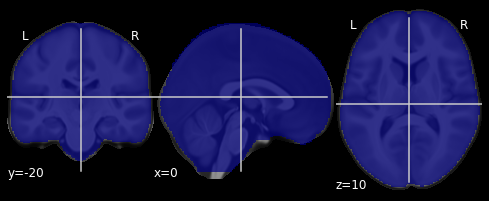

In [11]:
display = plotting.plot_roi(mask, template_brain)

Analyse data
------------

### 1. Create a design matrix
First create an adequate design matrix with three columns: 'age',
'sex', 'intercept'. For sex, sub_info DF encodes it as 'M' and 'F'. Turn this into a binary variable.

In [12]:
age = sub_info.Age.values
age

array([24.241, 22.943, 23.107, 22.916, 20.011, 23.715, 21.426, 23.745,
       20.843, 21.843, 19.825, 26.669, 23.08 , 25.374, 24.583, 21.465,
       20.233, 22.768, 21.065, 22.319, 24.55 , 23.17 , 27.433, 19.973,
       19.458, 22.908, 19.893, 20.509, 19.578, 22.806, 20.887, 24.014,
       25.766, 25.117, 18.815, 20.175, 26.031, 27.995, 22.864, 18.324,
       18.322, 18.762, 24.233, 26.335, 25.112, 27.28 , 18.272, 18.992,
       18.308, 19.529, 21.774, 20.912, 23.652, 26.264, 27.398, 23.088,
       26.064, 22.168, 20.846, 18.782, 26.026, 21.369, 27.258, 19.009,
       25.963, 26.672, 20.523, 22.768, 19.915, 18.847, 26.108, 19.641,
       24.564, 27.422, 22.757, 28.03 , 23.745, 19.789, 21.462, 20.044,
       23.173, 25.966, 23.995, 24.55 , 27.184, 26.292, 21.095, 23.138,
       20.044, 27.42 , 25.821, 25.377, 22.448, 18.94 , 21.807, 25.44 ,
       24.997, 23.636, 19.573, 20.485])

In [13]:
sex = np.array(sub_info.Sex.values == 'M')
sex

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False,  True,  True, False, False, False,
        True,  True,  True, False, False, False, False, False,  True,
        True, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False,  True, False, False,
        True])

 The intercept is simply a column with all 1.

In [14]:
intercept = np.ones(n_subjects)

Nistats accepts design matrix in the form of pandas dataframe. So we create a numpy array of sex, age, and intercept, and give the column names.

In [15]:
my_arr = np.vstack((sex, sub_info.Age.values, intercept))
my_arr.shape

(3, 100)

The shape indicates that the number of rows is 3. We simply swap the row and column (i.e. transpose) so that the number of columns is 3 for creation of the new DF.

In [69]:
design_matrix = pd.DataFrame(my_arr.T,
                            columns=['sex', 'age', 'intercept'])
design_matrix.head()

,sex,age,intercept
0,1.0,24.241,1.0
1,0.0,22.943,1.0
2,1.0,23.107,1.0
3,1.0,22.916,1.0
4,1.0,20.011,1.0


Plot the design matrix



In [70]:
len(design_matrix)

100

Text(30.25, 0.5, 'maps')

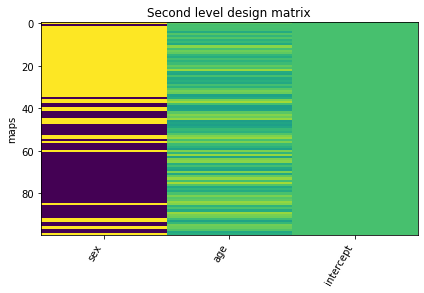

In [17]:
from nistats.reporting import plot_design_matrix
ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('maps')

### 2. Fit the model

Specify and fit the second-level model when loading the data, using SecondLevelModel from nistats.second_level_model. We can specify the level of smoothing to be applied to the data (to improve statistical behavior) and also provide a mask to restrict the analysis inside the mask image.


In [18]:
from nistats.second_level_model import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=4.0, mask=mask)
second_level_model.fit(gray_matter_map_filenames,
                       design_matrix=design_matrix)

/home/padawan/anaconda3/envs/cajal2019/lib/python3.7/site-packages/nilearn/image/image.py:455: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  not isinstance(imgs, collections.Iterable)):
/home/padawan/anaconda3/envs/cajal2019/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


SecondLevelModel(mask='/data/rw_eleves/Cajal-Morphometry2019/templates/brainmask_111.nii',
                 memory=None, memory_level=1, minimize_memory=True, n_jobs=1,
                 smoothing_fwhm=4.0, verbose=0)

Estimate the contrast is very simple. We can just provide the column
name of the design matrix (e.g. 'sex'), or manually specify, as below.



In [19]:
sex_z_map = second_level_model.compute_contrast(second_level_contrast=[1, 0, 0],
                                                output_type='z_score')

Plot the unthresholded zmap using plotting function from nilearn package.

/home/padawan/anaconda3/envs/cajal2019/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


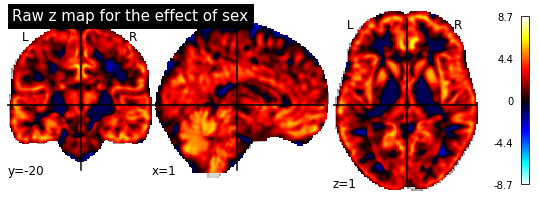

In [20]:
display = plotting.plot_stat_map(sex_z_map, title='Raw z map for the effect of sex')

You can also plot the thresholded map at uncorrected p < 0.05.
Nistats provide a tool to threshold your map very easily.

In [21]:
from nistats.thresholding import map_threshold

In [22]:
thresholded_map1, threshold1 = map_threshold(
    sex_z_map, level=.05, cluster_threshold=0)
print('The uncorrected threshold is %.3g' % threshold1)

The uncorrected threshold is 1.64


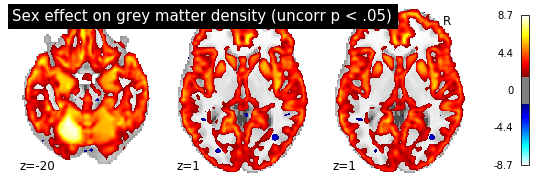

In [23]:
plotting.plot_stat_map(
    sex_z_map, threshold=threshold1, colorbar=True, display_mode='z',
    cut_coords=display.cut_coords,
    title='Sex effect on grey matter density (uncorr p < .05)')

### Correction for multiple comparisons

The map above is actually too liberal, since you are supposed to correct for the fact
that you are testing your model on many, many voxels at the same time!

You can read more about the problem of multiple comparisons in neuroimaging here:

(under resources)
* Zen_and_Art_of_Miltiple_comparisons.pdf
* Non-parametric_methods_and_RFT.pdf
* Nichols_Thresholding.pdf


Nistats offers the basic thresholding using FDR or Bonferoni. I recommend using either SnPM (https://warwick.ac.uk/fac/sci/statistics/staff/academic-research/nichols/software/snpm), FSL randomise (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Randomise), or more newly developped (and still in development) PALM (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/PALM) for the most strict test of your hypotheses, but to get the rough ideas about hox your effects loom like, the basic FDR correction can be good enough, as all the non-parametric methods can take lots of time and memory.

So let's continue looking at the result using a few other ways of thresholding.

First, we threshold at cluster-forming (uncorrected) p <0.001 with only clusters larger than 10 voxels. 

In [24]:
thresholded_map2, threshold2 = map_threshold(
    sex_z_map, level=.001,  height_control='fpr', cluster_threshold=5)
print('The uncorrected threshold is %.3g' % threshold2)

The uncorrected threshold is 3.09


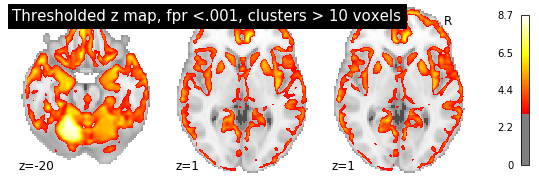

In [32]:
plotting.plot_stat_map(
    thresholded_map2, threshold=threshold2, colorbar=True, display_mode='z',
    cut_coords=display.cut_coords,
    title='Thresholded z map, fpr <.001, clusters > 10 voxels')

Next try using FDR threshold of p=0.05.

In [25]:
thresholded_map3, threshold3 = map_threshold(
    sex_z_map, level=.05, height_control='fdr')
print('The FDR=.05-corrected threshold is: %.3g' % threshold3)

The FDR=.05-corrected threshold is: 1.89


Then try plotting it.

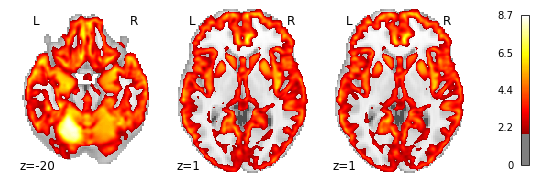

In [26]:
plotting.plot_stat_map(
    thresholded_map3, threshold=threshold3, colorbar=True, display_mode='z',
    cut_coords=display.cut_coords)

Finally try using FWER correction with Bonferroni.

In [27]:
thresholded_map4, threshold4 = map_threshold(
    sex_z_map, level=.05, height_control='bonferroni')
print('The p<.05 Bonferroni-corrected threshold is %.3g' % threshold4)

The p<.05 Bonferroni-corrected threshold is 5.44


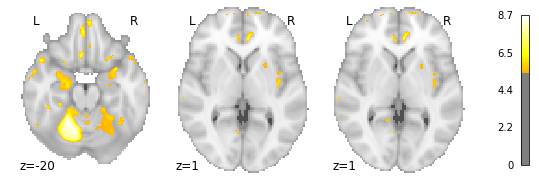

In [28]:
plotting.plot_stat_map(
    thresholded_map4, threshold=threshold4, colorbar=True, display_mode='z',
    cut_coords=display.cut_coords)

Notice that in Nistats, all of the above thresholding manipulation is one-sided, meaning that you will only see z score passing the threhold on the positive contrast. So if you'd like to look at corrected z score for Female>Male rather than Male>Female, you need to compute z_map with negative contrast (e.g. [-1, 0, 0] to look at Female>Male map.

In Male>Female contrast we used to test diferent threhoslding approaches, we have big effects, regardless of the type of thresholding we use. This is actually to be expected. Can you see why?


## Exercise 1

In section below, try to get the contrast map for the reverse effect, or the effect of age (positive or negative). See if any contrast map survives for the chosen method of multiple comparisons.

In [29]:
sex_z_map_fVsM = second_level_model.compute_contrast(second_level_contrast=[-1, 0, 0],
                                                output_type='z_score')

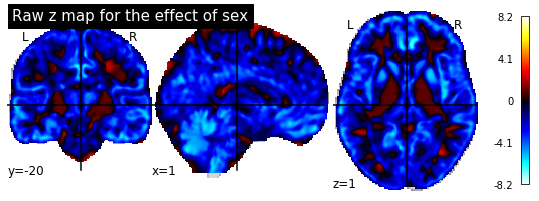

In [31]:
display = plotting.plot_stat_map(sex_z_map_fVsM, title='Raw z map for the effect of sex')

The uncorrected threshold is 3.09


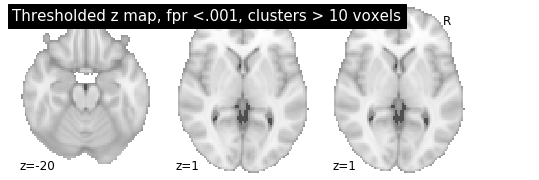

In [33]:
thresholded_map_A, threshold2 = map_threshold(
    sex_z_map_fVsM, level=.001,  height_control='fpr', cluster_threshold=5)
print('The uncorrected threshold is %.3g' % threshold2)

plotting.plot_stat_map(
    thresholded_map_A, threshold=threshold2, colorbar=True, display_mode='z',
    cut_coords=display.cut_coords,
    title='Thresholded z map, fpr <.001, clusters > 10 voxels')

The FDR=.05-corrected threshold is: inf


/home/padawan/anaconda3/envs/cajal2019/lib/python3.7/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


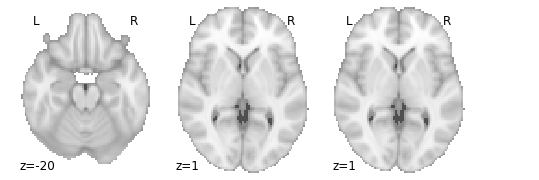

In [34]:
thresholded_map_B, threshold3 = map_threshold(
    sex_z_map_fVsM, level=.05, height_control='fdr')
print('The FDR=.05-corrected threshold is: %.3g' % threshold3)

plotting.plot_stat_map(
    thresholded_map_B, threshold=threshold3, colorbar=True, display_mode='z',
    cut_coords=display.cut_coords)

In [85]:
women = np.array(sub_info.Sex.values == 'F')
women

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True,  True, False, False,  True,  True,  True,
       False, False, False,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False,  True,  True,
       False])

## Exercise 2

In the model tested above, we tested the simplest model that assumed no interaction between Age and Sex.

This is not wrong, as long as you have no reason or interest to believe in the possibility of Age x Sex.

How could you modify the design matrix to test the interaction between Age and Sex?

Here are some useful resources if you are not sure;

* GLM and design matirx: background
stat_modeling.pdf
glm.pdf
(under resources folder)

* Design matrix and mean-centering
http://mumford.fmripower.org/mean_centering/

* Other examples of GLM and design matrices
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM



In [89]:
women = np.array(sub_info.Sex.values == 'F')
my_arr2 = np.vstack((sex, women, sub_info.Age.values, intercept))
my_arr.shape

design_matrix = pd.DataFrame(my_arr2.T,
                            columns=['Men','Women', 'age', 'intercept'])
design_matrix.head()




,Men,Women,age,intercept
0,1.0,0.0,24.241,1.0
1,0.0,1.0,22.943,1.0
2,1.0,0.0,23.107,1.0
3,1.0,0.0,22.916,1.0
4,1.0,0.0,20.011,1.0


In [93]:
design_matrix.insert(3,"MenAge",design_matrix.Men*design_matrix.age,True)
design_matrix.insert(4, "WomenAge",design_matrix.Women*design_matrix.age,True)

In [102]:
design_matrix = design_matrix.iloc[:,[0,1,3,4]]

In [103]:
design_matrix

,Men,Women,MenAge,WomenAge
0,1.0,0.0,24.241,0.000
1,0.0,1.0,0.000,22.943
2,1.0,0.0,23.107,0.000
3,1.0,0.0,22.916,0.000
4,1.0,0.0,20.011,0.000
...,...,...,...,...
95,0.0,1.0,0.000,25.440
96,1.0,0.0,24.997,0.000
97,0.0,1.0,0.000,23.636
98,0.0,1.0,0.000,19.573


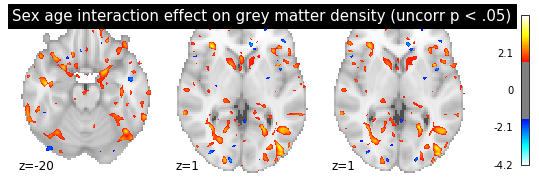

In [104]:
second_level_model = SecondLevelModel(smoothing_fwhm=4.0, mask=mask)
second_level_model.fit(gray_matter_map_filenames,
                       design_matrix=design_matrix)

sex_age_z_map = second_level_model.compute_contrast(second_level_contrast=[0, 0, -1, 1,],
                                                output_type='z_score')

plotting.plot_stat_map(
    sex_age_z_map, threshold=threshold1, colorbar=True, display_mode='z',
    cut_coords=display.cut_coords,
    title='Sex age interaction effect on grey matter density (uncorr p < .05)')


In [105]:

sex_age_z_map_men = second_level_model.compute_contrast(second_level_contrast=[0, 0, 0, 1],
                                                output_type='z_score')


sex_age_z_map_women = second_level_model.compute_contrast(second_level_contrast=[0, 0, 1, 0],
                                                output_type='z_score')

The uncorrected threshold is 1.64
The uncorrected threshold is 1.64


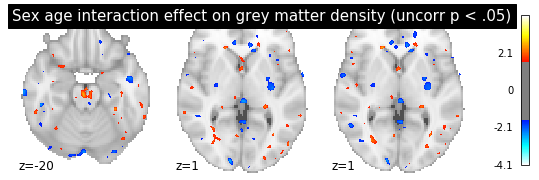

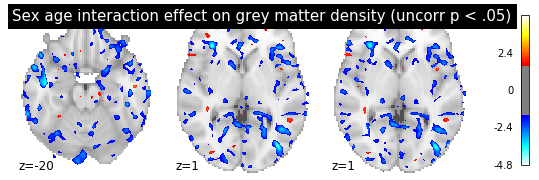

In [106]:
thresholded_map1, threshold1 = map_threshold(
    sex_age_z_map_men, level=.05, cluster_threshold=0)
print('The uncorrected threshold is %.3g' % threshold1)

plotting.plot_stat_map(
    sex_age_z_map_men, threshold=threshold1, colorbar=True, display_mode='z',
    cut_coords=display.cut_coords,
    title='Sex age interaction effect on grey matter density (uncorr p < .05)')

thresholded_map1, threshold1 = map_threshold(
    sex_age_z_map_women, level=.05, cluster_threshold=0)
print('The uncorrected threshold is %.3g' % threshold1)

plotting.plot_stat_map(
    sex_age_z_map_women, threshold=threshold1, colorbar=True, display_mode='z',
    cut_coords=display.cut_coords,
    title='Sex age interaction effect on grey matter density (uncorr p < .05)')

The uncorrected threshold is 1.64


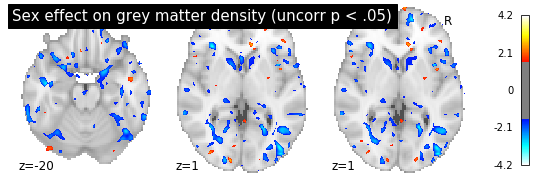

In [77]:
thresholded_map1, threshold1 = map_threshold(
    sex_age_z_map, level=.05, cluster_threshold=0)
print('The uncorrected threshold is %.3g' % threshold1)

plotting.plot_stat_map(
    sex_age_z_map, threshold=threshold1, colorbar=True, display_mode='z',
    cut_coords=display.cut_coords,
    title='Sex effect on grey matter density (uncorr p < .05)')

## Exercise 3

In the sub_info.csv, there is a column 'Score', representing a cognitive test score.
Can you create a new design matrix and contrast to investigate the effect of cognitive score, 
after controlling for age and sex?

In [ ]:
Cog_matrix = 

## Exercise 4

We used nistats and nilearn to perform the simple GLM analyses and view the results. However, you can use more conventional software packages (FSL, SPM, AFNI, etc) to perform the same analyses. They differ in how you specify desgin matrices/contrasts, how you can control for the multiple comparisons.

Because VBM is typically performed using SPM VBM pipeline, many use SPM for GLM as well. But you don't have to! You should choose the tools based on the features (eg. options for multiple comparison corrections) you desire.

Try using SPM or FSL to perform the same analysis you tried above.